<a href="https://colab.research.google.com/github/ganuwoahh/tdlta/blob/main/Week5_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

Autoencoder is a special type of neural network model whose goal is to learn a compressed representation of the input data that captures its most salient features. This compressed representation (latent space) can be used for a variety of tasks such as data compression, denoising, image generation and anomaly detection.

The Encoder tries to capture important information by reducing the dimensions of the input in latent space.

The Decoder tries to reconstruct the original image through the learnt representations.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns

We're going to use the Fashion MNIST dataset. It consists of black and white images of clothing articles. We're going to examine how well each encoder architecture can understand these images and how well they can reproduce them.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

fashion_mnist_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 213kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.87MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.28MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



We have to first reduce the dimensions between each activation function. This is to force the model to learn something. Else, the model will just spit out the input again with no change thereby not actually learning anything; by-hearting the input.

In [ ]:
class BasicAutoencoder(nn.Module):
    def __init__(self, input_dim=784, encoding_dim=32):
        super(BasicAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), # 784 inputs to 128
            nn.ReLU(),
            nn.Linear(128, 64), # 128 inputs to 64
            nn.ReLU(),
            nn.Linear(64, encoding_dim) # 64 inputs to 32
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64), # 32 inputs to 64
            nn.ReLU(),
            nn.Linear(64, 128), # 64 inputs to 128
            nn.ReLU(),
            nn.Linear(128, input_dim), # 128 inputs to 784
            nn.Sigmoid() # MNIST is black and white so all pixel values lie between 0 and 1
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) # flattening input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = BasicAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(10):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = F.mse_loss(recon_batch, data.view(-1, 784))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch}: Average loss = {total_loss}')

Epoch 0: Average loss = 20.137219602242112
Epoch 1: Average loss = 10.884788753464818
Epoch 2: Average loss = 9.802161747589707
Epoch 3: Average loss = 9.02909159194678
Epoch 4: Average loss = 8.487895557656884
Epoch 5: Average loss = 7.9854926420375705
Epoch 6: Average loss = 7.559764713048935
Epoch 7: Average loss = 7.2516287406906486
Epoch 8: Average loss = 6.99250278249383
Epoch 9: Average loss = 6.760610201396048


## Denoising Autoencoders


Denoising Autoencoder adds an extra step to the process. It adds noise to the input before encoding. This means that the model is forced to remove the noise to actually learn anything. This is achieved through the loss function comparing a clean image and the reconstructed image.

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim=784, encoding_dim=32): # same as the regular autoencoder
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def add_noise(self, x, noise_factor=0.3): # adding gaussian noise to input before encoding
        noisy = x + noise_factor * torch.randn_like(x)
        return torch.clamp(noisy, 0., 1.)

    def forward(self, x, add_noise=True):
        x = x.view(x.size(0), -1)
        if add_noise:
            x = self.add_noise(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
denoising_model = DenoisingAutoencoder().to(device)
optimizer = torch.optim.Adam(denoising_model.parameters(), lr=1e-3)

denoising_model.train()
for epoch in range(10):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = denoising_model(data)
        loss = F.mse_loss(recon_batch, data.view(-1, 784))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch}: Average loss = {total_loss}')

Epoch 0: Average loss = 21.854094112291932
Epoch 1: Average loss = 11.850135831162333
Epoch 2: Average loss = 10.848467748612165
Epoch 3: Average loss = 10.051176968961954
Epoch 4: Average loss = 9.442882223054767
Epoch 5: Average loss = 9.06667578034103
Epoch 6: Average loss = 8.794437680393457
Epoch 7: Average loss = 8.514686639420688
Epoch 8: Average loss = 8.28754472732544
Epoch 9: Average loss = 8.087797193787992


## Sparse Autoencoders

Sparse Autoencoders regulate learning through sparsity in the encoder neurons.

Since we're trying to learn a representation in the encoder, we need to make sure that the model learns which neurons are actually useful for encoding the information and is punished for unnecessary activations of neurons.

KL divergence punishes the model for activating a neuron too often as compared to the 0.05 sparsity parameter we've set. This means that only a few neurons should be active at any time and the rest should be close to 0.

This is important since we want the model to generalize and distribute the information learnt across the neurons.

In [ ]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim=784, encoding_dim=32, sparsity_param=0.05):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.Sigmoid() # adding a sigmoid here since we're trying to calculate the average activation of a neuron from 0 to 1 so we need to normalize
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

        self.sparsity_param = sparsity_param

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    def kl_divergence(self, p, q):
        return p * torch.log(p / q) + (1 - p) * torch.log((1 - p) / (1 - q))

    def sparsity_penalty(self, encoded):
        average_activation = torch.mean(encoded, dim=0) # calculating the average activation
        return torch.sum(self.kl_divergence(self.sparsity_param, average_activation))

NameError: name 'nn' is not defined

In [ ]:
sparse_model = SparseAutoencoder().to(device)
optimizer = torch.optim.Adam(sparse_model.parameters(), lr=1e-3)

sparse_model.train()
for epoch in range(10):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, encoded = sparse_model(data)
        recon_loss = F.mse_loss(recon_batch, data.view(-1, 784))
        sparsity_loss = sparse_model.sparsity_penalty(encoded)
        loss = recon_loss + 0.01 * sparsity_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch}: Average loss = {total_loss}')

Epoch 0: Average loss = 33.52149584889412
Epoch 1: Average loss = 18.720716029405594
Epoch 2: Average loss = 14.548953825607896
Epoch 3: Average loss = 12.14639394916594
Epoch 4: Average loss = 11.194883555173874
Epoch 5: Average loss = 10.678524738177657
Epoch 6: Average loss = 10.346738616004586
Epoch 7: Average loss = 10.054966198280454
Epoch 8: Average loss = 9.73046376556158
Epoch 9: Average loss = 9.372189601883292


## Variational Autoencoders

VAEs are the combination of both the above autoencoders in a way.

VAEs use both KL divergence in the loss function for sparsity and noise creation through z-normalized latent space.



In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, encoding_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential( # create the encoder
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(64, encoding_dim) # two seperate layers. one is the mean and one is the variance
        self.fc_var = nn.Linear(64, encoding_dim) # we interpret them as such and then train the loss function such that it learns meaningful mu and log_var values

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x) # passing the 64 output to the fc layer to become the mean and log variance
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var) # converting log var into std
        eps = torch.randn_like(std)
        return mu + eps * std # z-normalization

    def decode(self, z):
        return self.decoder(z) # z is passed to the decoder such that it's a gaussian distribution

    def forward(self, x):
        x = x.view(x.size(0), -1)
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

VAEs are designed to learn images through the normal distribution. This is different to sparse autoencoders.

Sparse autoencoders have a deterministic latent space. The same image always leads to the same point in latent space.

VAEs don't do this. The latent space itself follows a normal distribution and we learn it's parameters (mu and log_var) to navigate it.

Similar inputs will have similar latent distributions which means it's better

In [ ]:
vae_model = VAE().to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)

vae_model.train()
for epoch in range(10):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae_model(data)
        recon_loss = F.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch}: Average loss = {total_loss / len(train_loader.dataset):.4f}') # ignore the exact numbers from this loss as it's in a latent space so that numbers are arbitrary

Epoch 0: Average loss = 311.5721
Epoch 1: Average loss = 268.6297
Epoch 2: Average loss = 259.8990
Epoch 3: Average loss = 254.7585
Epoch 4: Average loss = 251.7149
Epoch 5: Average loss = 249.7276
Epoch 6: Average loss = 248.4434
Epoch 7: Average loss = 247.5064
Epoch 8: Average loss = 246.7586
Epoch 9: Average loss = 246.1639


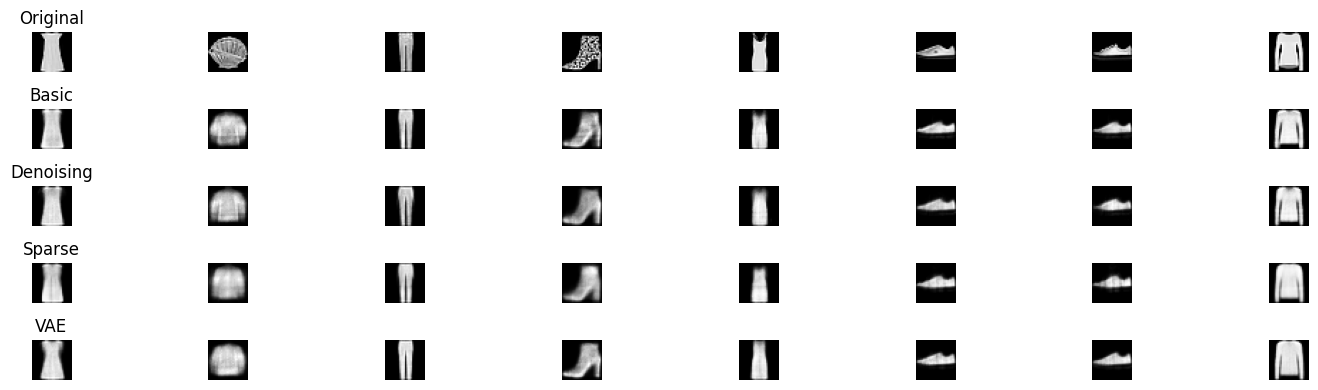

In [ ]:
with torch.no_grad():
    data, labels = next(iter(train_loader))
    data = data[:8].to(device)
    labels = labels[:8]

    basic_recon = model(data)
    denoising_recon = denoising_model(data)
    sparse_recon = sparse_model(data)[0]
    vae_recon = vae_model(data)[0]

    plt.figure(figsize=(15, 4))
    for i in range(8):
        # original
        plt.subplot(5, 8, i + 1)
        plt.imshow(data[i].cpu().squeeze(), cmap='gray')
        if i == 0:
            plt.title('Original')
        plt.xlabel(fashion_mnist_labels[labels[i]])
        plt.axis('off')

        # basic
        plt.subplot(5, 8, i + 9)
        plt.imshow(basic_recon[i].cpu().view(28, 28), cmap='gray')
        if i == 0:
            plt.title('Basic')
        plt.axis('off')

        # denoising
        plt.subplot(5, 8, i + 17)
        plt.imshow(denoising_recon[i].cpu().view(28, 28), cmap='gray')
        if i == 0:
            plt.title('Denoising')
        plt.axis('off')

        # sparse
        plt.subplot(5, 8, i + 25)
        plt.imshow(sparse_recon[i].cpu().view(28, 28), cmap='gray')
        if i == 0:
            plt.title('Sparse')
        plt.axis('off')

        # VAE
        plt.subplot(5, 8, i + 33)
        plt.imshow(vae_recon[i].cpu().view(28, 28), cmap='gray')
        if i == 0:
            plt.title('VAE')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

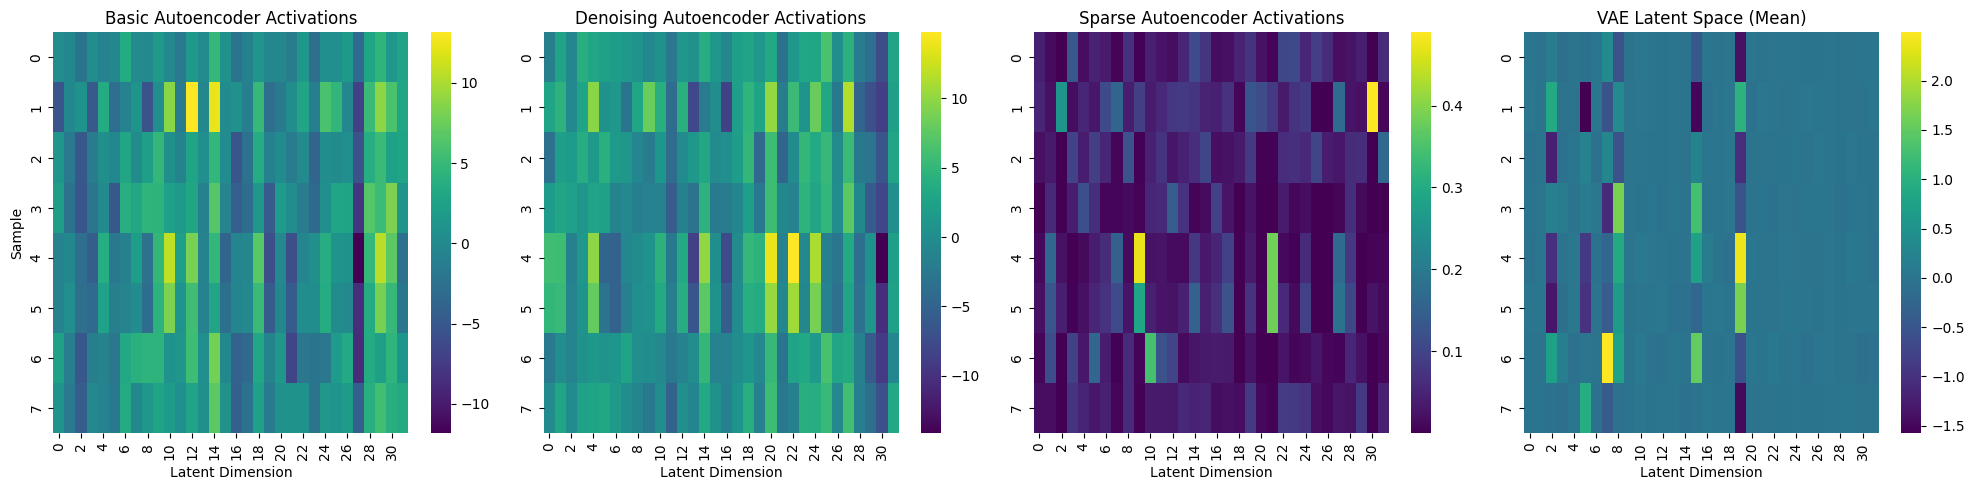

In [ ]:
with torch.no_grad():
    data, labels = next(iter(train_loader))
    data = data[:8].to(device)

    basic_encoded = model.encoder(data.view(data.size(0), -1))

    denoising_encoded = denoising_model.encoder(data.view(data.size(0), -1))

    sparse_encoded = sparse_model.encoder(data.view(data.size(0), -1))

    vae_encoded, _ = vae_model.encode(data.view(data.size(0), -1))

    plt.figure(figsize=(20, 5))

    # basic
    plt.subplot(141)
    sns.heatmap(basic_encoded.cpu().numpy(), cmap='viridis')
    plt.title('Basic Autoencoder Activations')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Sample')

    # denoising
    plt.subplot(142)
    sns.heatmap(denoising_encoded.cpu().numpy(), cmap='viridis')
    plt.title('Denoising Autoencoder Activations')
    plt.xlabel('Latent Dimension')
S
    # sparse
    plt.subplot(143)
    sns.heatmap(sparse_encoded.cpu().numpy(), cmap='viridis')
    plt.title('Sparse Autoencoder Activations')
    plt.xlabel('Latent Dimension')

    # VAE
    plt.subplot(144)
    sns.heatmap(vae_encoded.cpu().numpy(), cmap='viridis')
    plt.title('VAE Latent Space (Mean)')
    plt.xlabel('Latent Dimension')

    plt.tight_layout()
    plt.show()

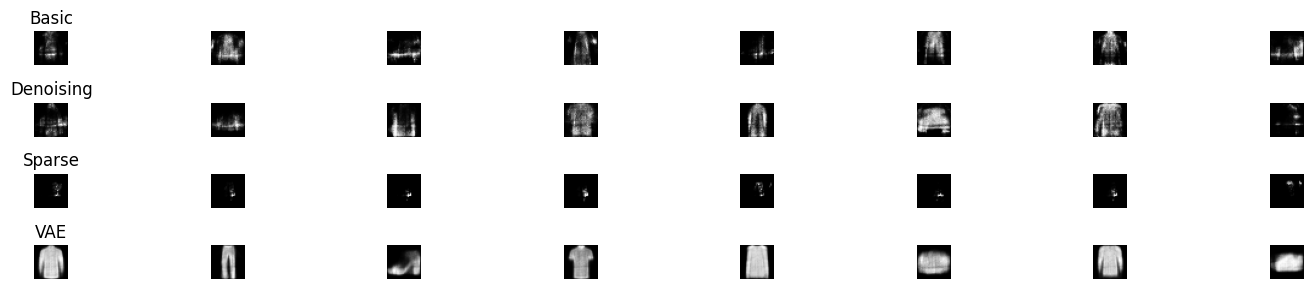

In [ ]:
with torch.no_grad():
    n_samples = 8

    encoded_stats = model.encoder(data.view(data.size(0), -1))
    mean, std = encoded_stats.mean(), encoded_stats.std()
    z_basic = mean + std * torch.randn(n_samples, 32).to(device)

    basic_generated = model.decoder(z_basic)

    denoising_generated = denoising_model.decoder(z_basic)

    z_sparse = torch.rand(n_samples, 32).to(device)
    sparse_generated = sparse_model.decoder(z_sparse)

    z_vae = torch.randn(n_samples, 32).to(device)
    vae_generated = vae_model.decode(z_vae)

    plt.figure(figsize=(15, 3))

    for i in range(n_samples):
        # basic
        plt.subplot(4, n_samples, i + 1)
        plt.imshow(basic_generated[i].cpu().view(28, 28), cmap='gray')
        if i == 0:
            plt.title('Basic')
        plt.axis('off')

        # denoising
        plt.subplot(4, n_samples, i + 1 + n_samples)
        plt.imshow(denoising_generated[i].cpu().view(28, 28), cmap='gray')
        if i == 0:
            plt.title('Denoising')
        plt.axis('off')

        # sparse
        plt.subplot(4, n_samples, i + 1 + 2*n_samples)
        plt.imshow(sparse_generated[i].cpu().view(28, 28), cmap='gray')
        if i == 0:
            plt.title('Sparse')
        plt.axis('off')

        # VAE
        plt.subplot(4, n_samples, i + 1 + 3*n_samples)
        plt.imshow(vae_generated[i].cpu().view(28, 28), cmap='gray')
        if i == 0:
            plt.title('VAE')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

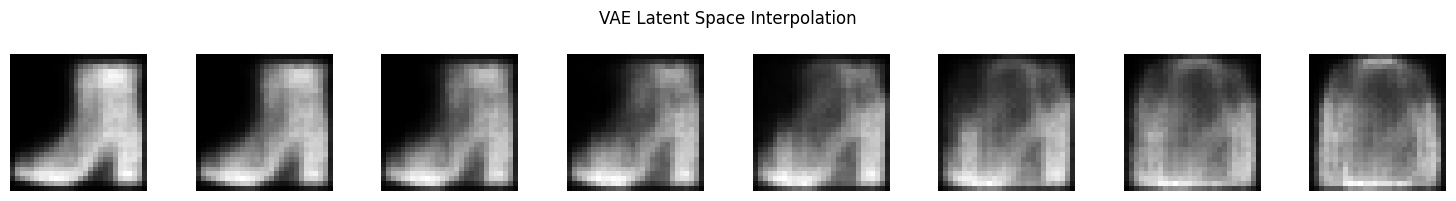

In [ ]:
 def interpolate_points(p1, p2, n_steps=10):
    ratios = torch.linspace(0, 1, n_steps)
    vectors = []
    for ratio in ratios:
        v = p1 * (1.0 - ratio) + p2 * ratio
        vectors.append(v)
    return torch.stack(vectors)

with torch.no_grad():
    z1 = torch.randn(1, 32).to(device)
    z2 = torch.randn(1, 32).to(device)

    z_interpolated = interpolate_points(z1, z2, n_steps=8)

    interpolated_images = vae_model.decode(z_interpolated)

    plt.figure(figsize=(15, 2))
    for i in range(8):
        plt.subplot(1, 8, i + 1)
        plt.imshow(interpolated_images[i].cpu().view(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle('VAE Latent Space Interpolation')
    plt.tight_layout()
    plt.show()